## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [1]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import gdown
from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [2]:
!gdown --id 1Y4Yzh1uTLIBLnJq1_QvoosFx9giiR1_K #Downloads the dataset from the drive

Downloading...
From: https://drive.google.com/uc?id=1Y4Yzh1uTLIBLnJq1_QvoosFx9giiR1_K
To: /content/complaints-2021-05-14_08_16_.json
100% 83.4M/83.4M [00:00<00:00, 132MB/s]


In [3]:
# Opening JSON file 
f = open('/content/complaints-2021-05-14_08_16_.json')
  
# returns JSON object as  
# a dictionary 
data = json.load(f)
df=pd.json_normalize(data)

## Data preparation

In [4]:
# Inspect the dataframe to understand the given data.
df.head(10)

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,_source.consumer_disputed,_source.product,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,N/A,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A
5,complaint-public-v2,complaint,3275312,0.0,Older American,48227,3275312,Managing an account,2019-06-13T12:00:00-05:00,MI,N/A,Checking or savings account,Closed with monetary relief,JPMORGAN CHASE & CO.,Referral,2019-06-14T12:00:00-05:00,None,Checking account,Yes,,Problem using a debit or ATM card,N/A
6,complaint-public-v2,complaint,3238804,0.0,None,76262,3238804,Managing an account,2019-05-10T12:00:00-05:00,TX,N/A,Checking or savings account,Closed with monetary relief,JPMORGAN CHASE & CO.,Phone,2019-05-10T12:00:00-05:00,None,Checking account,Yes,,Problem using a debit or ATM card,N/A
7,complaint-public-v2,complaint,3249272,0.0,None,07753,3249272,Trouble during payment process,2019-05-15T12:00:00-05:00,NJ,N/A,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-05-21T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,N/A
8,complaint-public-v2,complaint,3351653,0.0,None,60621,3351653,Closing an account,2019-08-22T12:00:00-05:00,IL,N/A,Checking or savings account,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-08-23T12:00:00-05:00,None,Checking account,Yes,,Company closed your account,N/A
9,complaint-public-v2,complaint,3273612,0.0,None,99354,3273612,Managing an account,2019-06-11T12:00:00-05:00,WA,N/A,Checking or savings account,Closed with monetary relief,JPMORGAN CHASE & CO.,Referral,2019-06-17T12:00:00-05:00,None,Checking account,Yes,,Cashing a check,N/A


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

In [6]:
#print the column names
df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

**As the column names contain '_score' or ' _ ' at the beginning, we can remove them to make the column names more meaningful.**

In [7]:
#Assign new column names
df.rename(columns=lambda x: x.replace('_source.', ''), inplace=True)# Remove "_source" at the beginning
df.rename(columns=lambda x: x.strip('_'), inplace=True)# # Remove "_" at the beginning

df.head()

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,consumer_disputed,product,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,N/A,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [8]:
round(100*(df.isnull().sum()/len(df)), 2) #Checking the null value percentage for all the columns

index                         0.00
type                          0.00
id                            0.00
score                         0.00
tags                         86.08
zip_code                      8.63
complaint_id                  0.00
issue                         0.00
date_received                 0.00
state                         2.54
consumer_disputed             0.00
product                       0.00
company_response              0.00
company                       0.00
submitted_via                 0.00
date_sent_to_company          0.00
company_public_response      99.99
sub_product                  13.50
timely                        0.00
complaint_what_happened       0.00
sub_issue                    59.12
consumer_consent_provided     1.29
dtype: float64

**While the null percentage for 'complaint_what_happened' is 0, there are several rows with empty content for this foeld. Hence we will replace it with Nan and drop these rows from the dataset.**

In [9]:
#Assign nan in place of blank entries in the complaints column

df['complaint_what_happened'] = df['complaint_what_happened'].apply(lambda x : np.nan if x == "" else x)

In [10]:
round(100*(df.isnull().sum()/len(df)), 2)#Checking the null value percentage for all the columns

index                         0.00
type                          0.00
id                            0.00
score                         0.00
tags                         86.08
zip_code                      8.63
complaint_id                  0.00
issue                         0.00
date_received                 0.00
state                         2.54
consumer_disputed             0.00
product                       0.00
company_response              0.00
company                       0.00
submitted_via                 0.00
date_sent_to_company          0.00
company_public_response      99.99
sub_product                  13.50
timely                        0.00
complaint_what_happened      73.09
sub_issue                    59.12
consumer_consent_provided     1.29
dtype: float64

In [11]:
#Removing all the rows where complaints column is NaN
df = df[~(df.complaint_what_happened.isna())]

print(df.shape)

#Checking the null value percentage for all the columns again
round(100*(df.isnull().sum()/len(df)), 2)



(21072, 22)


index                         0.00
type                          0.00
id                            0.00
score                         0.00
tags                         81.89
zip_code                     22.04
complaint_id                  0.00
issue                         0.00
date_received                 0.00
state                         0.68
consumer_disputed             0.00
product                       0.00
company_response              0.00
company                       0.00
submitted_via                 0.00
date_sent_to_company          0.00
company_public_response      99.99
sub_product                  10.01
timely                        0.00
complaint_what_happened       0.00
sub_issue                    38.80
consumer_consent_provided     0.00
dtype: float64

**As we are mainly interested in complaint description to classify the category, we can ignore the other null values present in other columns**

In [12]:
# Final dataframe shape
df.shape

(21072, 22)

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Use POS tags to get relevant words from the texts.


In [13]:
# Write your function here to clean the text and remove all the unnecessary elements.

def process_complaint(feature):
    # convert the text to lowercase
    df[feature] = df[feature].apply(lambda i : i.lower())     
    
    # removing text which is present in square brackets using the regex
    df[feature] = df[feature].apply(lambda i : re.sub('\[(.*?)\]', "", i))
    
    # removing all the punctuations from the text using the regex
    df[feature] = df[feature].apply(lambda i : re.sub(r'[^\w\s]', '', i))
    
    # removing words which contains digits/numbers
    df[feature] = df[feature].apply(lambda i : re.sub('\S*\d+\S*', "", i))    

In [14]:
df['complaint_what_happened']

1        Good morning my name is XXXX XXXX and I apprec...
2        I upgraded my XXXX XXXX card in XX/XX/2018 and...
10       Chase Card was reported on XX/XX/2019. However...
11       On XX/XX/2018, while trying to book a XXXX  XX...
14       my grand son give me check for {$1600.00} i de...
                               ...                        
78303    After being a Chase Card customer for well ove...
78309    On Wednesday, XX/XX/XXXX I called Chas, my XXX...
78310    I am not familiar with XXXX pay and did not un...
78311    I have had flawless credit for 30 yrs. I've ha...
78312    Roughly 10+ years ago I closed out my accounts...
Name: complaint_what_happened, Length: 21072, dtype: object

In [15]:
# Printing a sample sentence 
print(df['complaint_what_happened'][2])

# Apply pre-processing function on the complaint_what_happened column
process_complaint('complaint_what_happened')

# print the same sentence after cleaning it 
df['complaint_what_happened'][2]

I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX   changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.


'i upgraded my xxxx xxxx card in  and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx   changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me'

In [16]:
# Load the spacy model. Here we are ignoring parser and ner as we don't use these pipelines for this usecase.
#from tqdm import tqdm
model = spacy.load('en_core_web_sm',disable=['parser','ner'])

In [17]:
#Write your function to Lemmatize the texts

# The below function first removes the stopwords and then lemmatizes it.

def func_lemma(text):      
    sent = [wordnet_lemmatizer.lemmatize(word) for word in word_tokenize(text) if not word in set(stopwords.words('english'))]
    return " ".join(sent)

In [18]:
# Lemmatizing the complaint_what_happened column

df['complaint_lemmatized'] = df['complaint_what_happened'].apply(lambda x : func_lemma(x))

In [19]:
# Print few rows post lemmatizing
df['complaint_lemmatized'][0:5]

1     good morning name xxxx xxxx appreciate could h...
2     upgraded xxxx xxxx card told agent upgrade ann...
10    chase card reported however fraudulent applica...
11    trying book xxxx xxxx ticket came across offer...
14    grand son give check deposit chase account fun...
Name: complaint_lemmatized, dtype: object

In [20]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 

df_clean = df[['complaint_what_happened', 'complaint_lemmatized']].copy()
print(df_clean.shape)

(21072, 2)


In [21]:
df_clean # View the dataframe

,complaint_what_happened,complaint_lemmatized
1,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...
2,i upgraded my xxxx xxxx card in and was told ...,upgraded xxxx xxxx card told agent upgrade ann...
10,chase card was reported on however fraudulent...,chase card reported however fraudulent applica...
11,on while trying to book a xxxx xxxx ticket ...,trying book xxxx xxxx ticket came across offer...
14,my grand son give me check for i deposit it i...,grand son give check deposit chase account fun...
...,...,...
78303,after being a chase card customer for well ove...,chase card customer well decade offered multip...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,wednesday xxxxxxxx called chas xxxx xxxx visa ...
78310,i am not familiar with xxxx pay and did not un...,familiar xxxx pay understand great risk provid...
78311,i have had flawless credit for yrs ive had ch...,flawless credit yr ive chase credit card chase...


In [22]:
#Write your function to extract the POS tags 

def func_pos_tag(sentence):
    nouns = []
    doc = model(sentence)
    
    for token in doc:
        if token.pos_ == 'NOUN' or token.pos_ == 'PROPN':# We are extracting tokens with POS tags of NOUN and PROPN
            nouns.append(token.text)
            
    sent_with_nouns = " ".join(nouns)        
    return sent_with_nouns

In [23]:
# New column is added which contains complaint of words having only NOUN tags
df_clean['complaint_POS_removed'] = df_clean['complaint_lemmatized'].apply(lambda x : func_pos_tag(x))

In [24]:
# View few rows post removing POS tags
df_clean['complaint_POS_removed'][0:5]

1     morning name xxxx xxxx chase bank cardmember s...
2     upgraded xxxx xxxx card agent upgrade annivers...
10    chase card application identity consent servic...
11    trying book xxxx xxxx ticket offer ticket rewa...
14    grand son check deposit chase account fund cle...
Name: complaint_POS_removed, dtype: object

In [25]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean

,complaint_what_happened,complaint_lemmatized,complaint_POS_removed
1,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...,morning name xxxx xxxx chase bank cardmember s...
2,i upgraded my xxxx xxxx card in and was told ...,upgraded xxxx xxxx card told agent upgrade ann...,upgraded xxxx xxxx card agent upgrade annivers...
10,chase card was reported on however fraudulent...,chase card reported however fraudulent applica...,chase card application identity consent servic...
11,on while trying to book a xxxx xxxx ticket ...,trying book xxxx xxxx ticket came across offer...,trying book xxxx xxxx ticket offer ticket rewa...
14,my grand son give me check for i deposit it i...,grand son give check deposit chase account fun...,grand son check deposit chase account fund cle...
...,...,...,...
78303,after being a chase card customer for well ove...,chase card customer well decade offered multip...,chase card customer decade solicitation credit...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,wednesday xxxxxxxx called chas xxxx xxxx visa ...,wednesday xxxxxxxx chas xxxx xxxx visa credit ...
78310,i am not familiar with xxxx pay and did not un...,familiar xxxx pay understand great risk provid...,familiar xxxx risk consumer chase bank app cha...
78311,i have had flawless credit for yrs ive had ch...,flawless credit yr ive chase credit card chase...,credit yr chase credit card chase freedom xxxx...


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




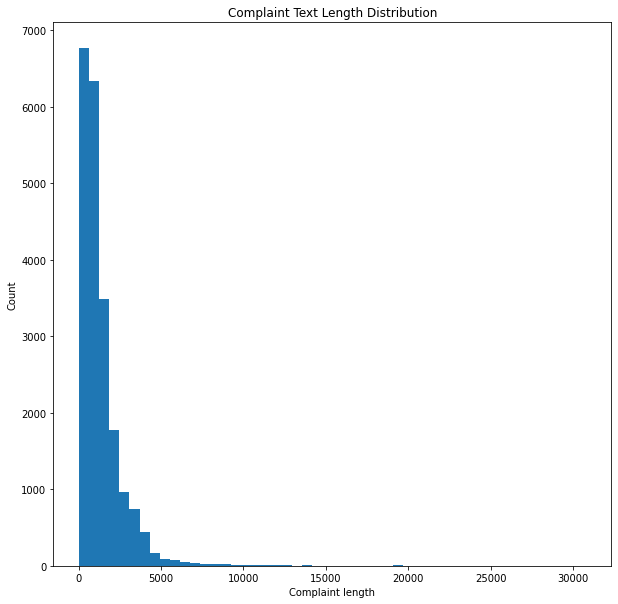

In [26]:
# Write your code here to visualise the data according to the 'Complaint' character length
df_clean['complaint_length'] = df_clean['complaint_what_happened'].astype(str).apply(len)
df_clean['complaint_length_POS_removed'] = df_clean['complaint_POS_removed'].astype(str).apply(len)

plt.figure(figsize=(10,10))
df_clean['complaint_length'].plot.hist(bins=50, title='Complaint Text Length Distribution')
plt.xlabel('Complaint length')
plt.ylabel('Count')
plt.show()

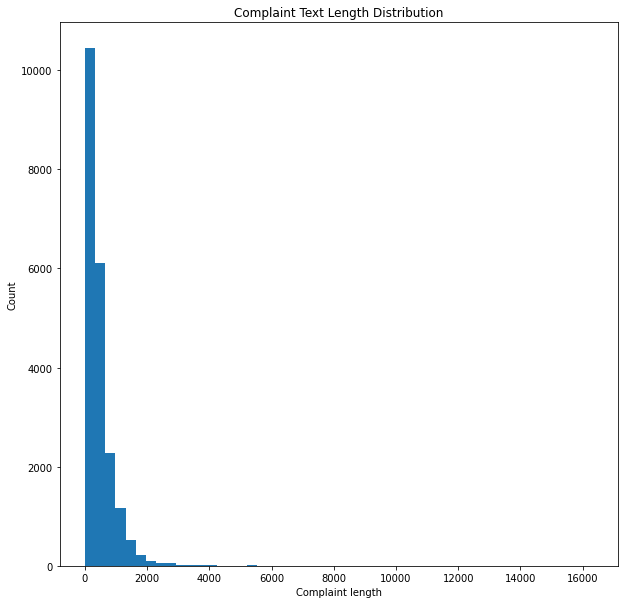

In [27]:
plt.figure(figsize=(10,10))
df_clean['complaint_length_POS_removed'].plot.hist(bins=50, title='Complaint Text Length Distribution')
plt.xlabel('Complaint length')
plt.ylabel('Count')
plt.show()

**As we can see ffrom the above 2 plots, post removing the POS tags, the word length of the complaints have come down significantly and number of sentences with lower word count has increased.**

#### Find the top 40 words by frequency among all the articles after processing the text.

In [28]:
!pip install wordcloud

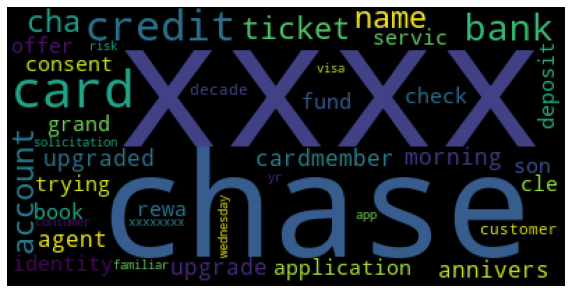

In [29]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
from wordcloud import WordCloud
stop_words = set(stopwords.words('english'))

wordCloud = WordCloud(stopwords=stop_words,max_words=40).generate(str(df_clean.complaint_POS_removed))

plt.figure(figsize=(10,10))
plt.imshow(wordCloud)
plt.axis('off')
plt.show();

In [30]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

In [31]:
df_clean.head()

,complaint_what_happened,complaint_lemmatized,complaint_POS_removed,complaint_length,complaint_length_POS_removed,Complaint_clean
1,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...,morning name xxxx xxxx chase bank cardmember s...,475,195,morning name xxxx xxxx chase bank cardmember s...
2,i upgraded my xxxx xxxx card in and was told ...,upgraded xxxx xxxx card told agent upgrade ann...,upgraded xxxx xxxx card agent upgrade annivers...,337,153,upgraded xxxx xxxx card agent upgrade annivers...
10,chase card was reported on however fraudulent...,chase card reported however fraudulent applica...,chase card application identity consent servic...,210,73,chase card application identity consent servic...
11,on while trying to book a xxxx xxxx ticket ...,trying book xxxx xxxx ticket came across offer...,trying book xxxx xxxx ticket offer ticket rewa...,1433,453,trying book xxxx xxxx ticket offer ticket rewa...
14,my grand son give me check for i deposit it i...,grand son give check deposit chase account fun...,grand son check deposit chase account fund cle...,456,222,grand son check deposit chase account fund cle...


#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [32]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 
def fetch_unigrams(sents, count):
    vector = CountVectorizer(ngram_range=(1, 1), stop_words='english').fit(sents)
    bagOfWords = vector.transform(sents)
    sumOfWords = bagOfWords.sum(axis=0)
    
    wordFrequency = [(k, sumOfWords[0, i]) for k, i in vector.vocabulary_.items()]
    wordFrequency =sorted(wordFrequency, key = lambda x: x[1], reverse=True)
    
    return wordFrequency[:count]

In [33]:
unigrams = fetch_unigrams(df_clean['Complaint_clean'], 30)

  Unigram word  Frequency
0         xxxx     188516
1        chase      78881
2      account      47540
3       credit      32975
4         card      30482
5         bank      28202
6     xxxxxxxx      27861
7      payment      21142
8         time      16030
9          day      12950


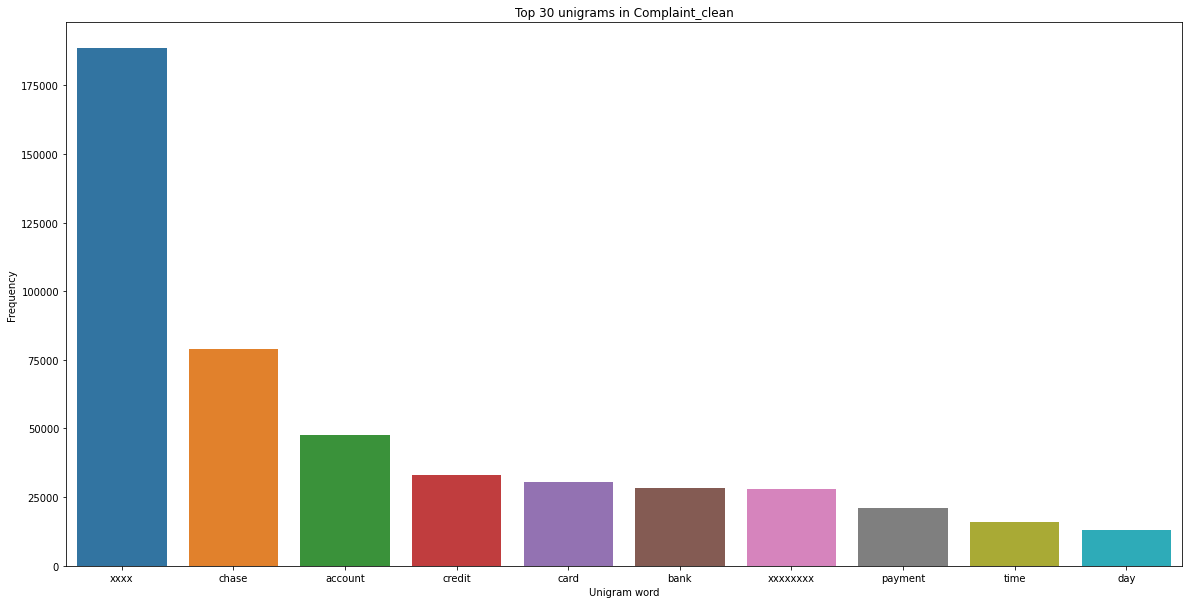

In [34]:
#Print the top 10 words in the unigram frequency
unigrams_df = pd.DataFrame(unigrams, columns=['Unigram word', 'Frequency'])
print(unigrams_df.head(10))

plt.figure(figsize=[20,10])
fig = sns.barplot(x=unigrams_df['Unigram word'][:10], y=unigrams_df['Frequency'][:10])
plt.title('Top 30 unigrams in Complaint_clean')
plt.show()

In [35]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 
def fetch_bigrams(sents, count):
    vector = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(sents)
    bagOfWords = vector.transform(sents)
    sumOfWords = bagOfWords.sum(axis=0)
    
    wordFrequency = [(k, sumOfWords[0, i]) for k, i in vector.vocabulary_.items()]
    wordFrequency =sorted(wordFrequency, key = lambda x: x[1], reverse=True)
    
    return wordFrequency[:count]

In [36]:
bigrams = fetch_bigrams(df_clean['Complaint_clean'], 30)

     Bigram word  Frequency
0      xxxx xxxx      87506
1     chase bank      12881
2    credit card      12847
3     xxxx chase       6818
4     chase xxxx       4143
5  xxxxxxxx xxxx       4090
6   account xxxx       4014
7  account chase       3917
8  credit report       3871
9   chase credit       3554


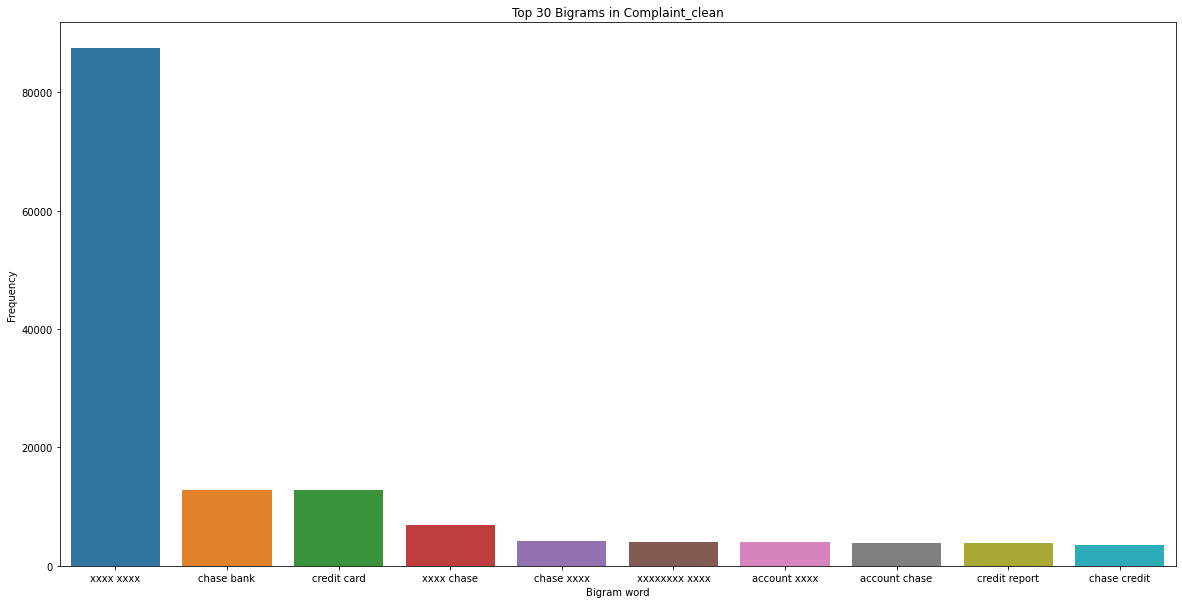

In [37]:
#Print the top 10 words in the bigram frequency
bigrams_df = pd.DataFrame(bigrams, columns=['Bigram word', 'Frequency'])
print(bigrams_df.head(10))

plt.figure(figsize=[20,10])
fig = sns.barplot(x=bigrams_df['Bigram word'][:10], y=bigrams_df['Frequency'][:10])
plt.title('Top 30 Bigrams in Complaint_clean')
plt.show()

In [38]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 
def fetch_trigrams(sents, count):
    vector = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(sents)
    bagOfWords = vector.transform(sents)
    sumOfWords = bagOfWords.sum(axis=0)
    
    wordFrequency = [(k, sumOfWords[0, i]) for k, i in vector.vocabulary_.items()]
    wordFrequency =sorted(wordFrequency, key = lambda x: x[1], reverse=True)
    
    return wordFrequency[:count]

In [39]:
trigrams = fetch_trigrams(df_clean['Complaint_clean'], 30)

         Trigram word  Frequency
0      xxxx xxxx xxxx      43743
1     xxxx xxxx chase       3082
2   chase credit card       2426
3     jp morgan chase       2349
4  xxxxxxxx xxxx xxxx       2018
5     chase xxxx xxxx       1606
6  xxxx xxxx xxxxxxxx       1584
7   account xxxx xxxx       1553
8   xxxx xxxx account       1383
9    xxxx credit card       1257


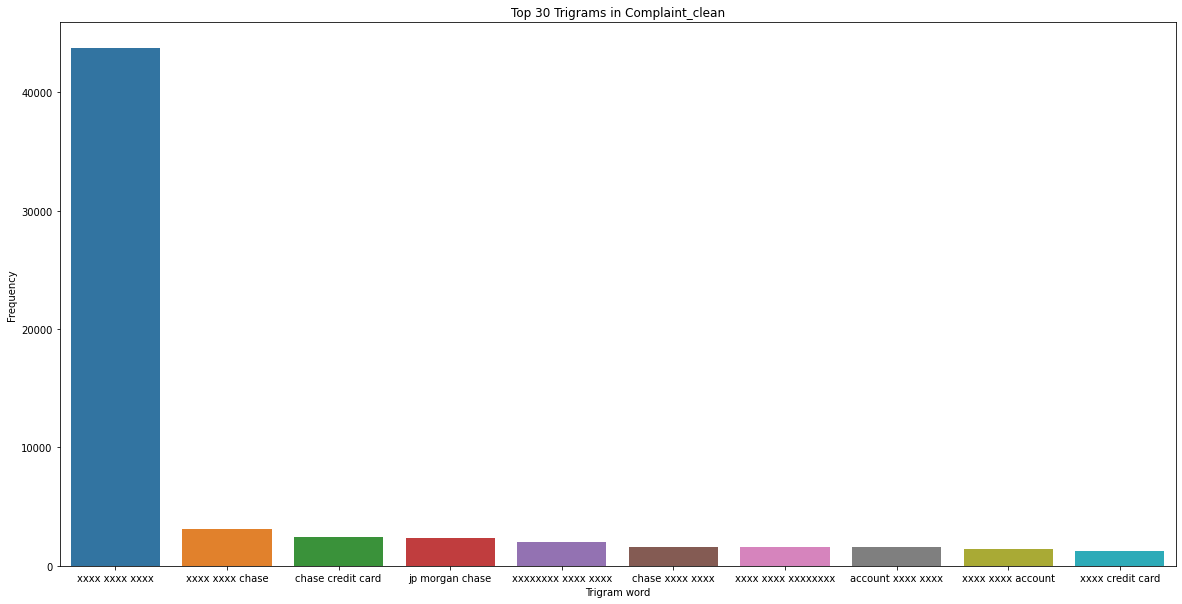

In [40]:
#Print the top 10 words in the trigram frequency
trigrams_df = pd.DataFrame(trigrams, columns=['Trigram word', 'Frequency'])
print(trigrams_df.head(10))

plt.figure(figsize=[20,10])
fig = sns.barplot(x=trigrams_df['Trigram word'][:10], y=trigrams_df['Frequency'][:10])
plt.title('Top 30 Trigrams in Complaint_clean')
plt.show()

## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [41]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [42]:
#All masked texts has been removed
df_clean

,complaint_what_happened,complaint_lemmatized,complaint_POS_removed,complaint_length,complaint_length_POS_removed,Complaint_clean
1,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...,morning name xxxx xxxx chase bank cardmember s...,475,195,morning name chase bank cardmember service c...
2,i upgraded my xxxx xxxx card in and was told ...,upgraded xxxx xxxx card told agent upgrade ann...,upgraded xxxx xxxx card agent upgrade annivers...,337,153,upgraded card agent upgrade anniversary date...
10,chase card was reported on however fraudulent...,chase card reported however fraudulent applica...,chase card application identity consent servic...,210,73,chase card application identity consent servic...
11,on while trying to book a xxxx xxxx ticket ...,trying book xxxx xxxx ticket came across offer...,trying book xxxx xxxx ticket offer ticket rewa...,1433,453,trying book ticket offer ticket reward card ...
14,my grand son give me check for i deposit it i...,grand son give check deposit chase account fun...,grand son check deposit chase account fund cle...,456,222,grand son check deposit chase account fund cle...
...,...,...,...,...,...,...
78303,after being a chase card customer for well ove...,chase card customer well decade offered multip...,chase card customer decade solicitation credit...,650,237,chase card customer decade solicitation credit...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,wednesday xxxxxxxx called chas xxxx xxxx visa ...,wednesday xxxxxxxx chas xxxx xxxx visa credit ...,2067,707,wednesday chas visa credit card provider cl...
78310,i am not familiar with xxxx pay and did not un...,familiar xxxx pay understand great risk provid...,familiar xxxx risk consumer chase bank app cha...,2296,783,familiar risk consumer chase bank app chase y...
78311,i have had flawless credit for yrs ive had ch...,flawless credit yr ive chase credit card chase...,credit yr chase credit card chase freedom xxxx...,2009,590,credit yr chase credit card chase freedom pro...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [43]:
#Write your code here to initialise the TfidfVectorizer 
tfIdf_vector = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=2)

tfidf = tfIdf_vector.fit(df_clean.Complaint_clean)

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [44]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
dtm = tfIdf_vector.fit_transform(df_clean.Complaint_clean)

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [45]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [46]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5 #write the value you want to test out

#keep the random_state =40
nmf_model = NMF(n_components = num_topics, random_state = 40)

In [47]:
nmf_model.fit(dtm)
len(tfIdf_vector.get_feature_names())

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning:

The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



8828

In [48]:
W = nmf_model.fit_transform(dtm)
H = nmf_model.components_

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning:

The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).



In [49]:
print(W.shape)#Print shape of W matrix
print(H.shape)#Print shape of H matrix

(21072, 5)
(5, 8828)


In [50]:
#Print the Top15 words for each of the topics
features = np.array(tfIdf_vector.get_feature_names())

# Creating dataframe with featues and the topic-term matrix H
topicWords = pd.DataFrame(np.zeros((num_topics, 15)), index=[f'Topic {i}' for i in range(num_topics)], columns=[f'Word {i}' for i in range(15)]).astype(str)

for i in range(num_topics):
    ix = H[i].argsort()[::-1][:15]
    topicWords.iloc[i] = features[ix]

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



In [51]:
topicWords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,account,bank,check,chase,money,fund,deposit,branch,day,business,number,transfer,transaction,customer,claim
Topic 1,credit,card,report,inquiry,chase,account,score,company,bureau,limit,debt,application,information,balance,year
Topic 2,loan,mortgage,chase,modification,home,property,year,letter,rate,bank,document,time,jp,morgan,house
Topic 3,charge,card,chase,dispute,transaction,merchant,fraud,fee,claim,purchase,service,refund,email,time,phone
Topic 4,payment,balance,fee,month,statement,pay,day,time,chase,date,auto,credit,year,account,car


In [52]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
W_dataframe = pd.DataFrame(W, columns=[f'Topic {i}' for i in range(num_topics) ])

# Best Topic column picks the topic with the highest weightage
W_dataframe['Best Topic'] = W.argmax(axis=1)

W_dataframe.head()

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Best Topic
0,0.025082,0.012671,0.024630,0.012071,0.005918,0
1,0.005762,0.008460,0.001127,0.009614,0.001947,3
2,0.000000,0.048351,0.002927,0.009004,0.000000,1
3,0.018396,0.053940,0.018950,0.011579,0.000000,1
4,0.061962,0.000000,0.006402,0.004267,0.000000,0


In [53]:
#Assign the best topic to each of the cmplaints in Topic Column

df_clean['Topic'] = W.argmax(axis=1)#write your code to assign topics to each rows.

In [54]:
df_clean.head()

,complaint_what_happened,complaint_lemmatized,complaint_POS_removed,complaint_length,complaint_length_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...,morning name xxxx xxxx chase bank cardmember s...,475,195,morning name chase bank cardmember service c...,0
2,i upgraded my xxxx xxxx card in and was told ...,upgraded xxxx xxxx card told agent upgrade ann...,upgraded xxxx xxxx card agent upgrade annivers...,337,153,upgraded card agent upgrade anniversary date...,3
10,chase card was reported on however fraudulent...,chase card reported however fraudulent applica...,chase card application identity consent servic...,210,73,chase card application identity consent servic...,1
11,on while trying to book a xxxx xxxx ticket ...,trying book xxxx xxxx ticket came across offer...,trying book xxxx xxxx ticket offer ticket rewa...,1433,453,trying book ticket offer ticket reward card ...,1
14,my grand son give me check for i deposit it i...,grand son give check deposit chase account fun...,grand son check deposit chase account fund cle...,456,222,grand son check deposit chase account fund cle...,0


In [55]:
#Print the first 5 Complaint for each of the Topics
df_clean_5=df_clean.groupby('Topic').head(5)
df_clean_5.sort_values('Topic')

,complaint_what_happened,complaint_lemmatized,complaint_POS_removed,complaint_length,complaint_length_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...,morning name xxxx xxxx chase bank cardmember s...,475,195,morning name chase bank cardmember service c...,0
24,mishandling of this account by chase auto and ...,mishandling account chase auto xxxx,account chase auto xxxx,50,23,account chase auto,0
17,with out notice jp morgan chase restricted my ...,notice jp morgan chase restricted account debi...,notice jp morgan chase account debit card tues...,2224,684,notice jp morgan chase account debit card tues...,0
14,my grand son give me check for i deposit it i...,grand son give check deposit chase account fun...,grand son check deposit chase account fund cle...,456,222,grand son check deposit chase account fund cle...,0
27,i opened an account with chase bank on xxxx an...,opened account chase bank xxxx used code xxxx ...,account chase bank xxxx code xxxx bonus follow...,403,134,account chase bank code bonus follow term a...,0
15,can you please remove inquiry,please remove inquiry,inquiry,29,7,inquiry,1
10,chase card was reported on however fraudulent...,chase card reported however fraudulent applica...,chase card application identity consent servic...,210,73,chase card application identity consent servic...,1
23,i have a chase credit card which is incorrectl...,chase credit card incorrectly reporting data c...,chase credit card data credit report company i...,127,50,chase credit card data credit report company i...,1
26,i have reached out to xxxx several times in at...,reached xxxx several time attempt fraudulent i...,xxxx time inquiry need call contact creditor i...,735,236,time inquiry need call contact creditor inqui...,1
11,on while trying to book a xxxx xxxx ticket ...,trying book xxxx xxxx ticket came across offer...,trying book xxxx xxxx ticket offer ticket rewa...,1433,453,trying book ticket offer ticket reward card ...,1


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [56]:
#Create the dictionary of Topic names and Topics

Topic_names = {0 : 'Bank Account services',
                1 : 'Credit card or prepaid card' ,
                2 : 'Mortgage/ Loan',
                3 : 'Theft/Dispute Reporting' , 
                4 : 'Others'}

In [57]:
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [58]:
df_clean.head()

,complaint_what_happened,complaint_lemmatized,complaint_POS_removed,complaint_length,complaint_length_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...,morning name xxxx xxxx chase bank cardmember s...,475,195,morning name chase bank cardmember service c...,Bank Account services
2,i upgraded my xxxx xxxx card in and was told ...,upgraded xxxx xxxx card told agent upgrade ann...,upgraded xxxx xxxx card agent upgrade annivers...,337,153,upgraded card agent upgrade anniversary date...,Theft/Dispute Reporting
10,chase card was reported on however fraudulent...,chase card reported however fraudulent applica...,chase card application identity consent servic...,210,73,chase card application identity consent servic...,Credit card or prepaid card
11,on while trying to book a xxxx xxxx ticket ...,trying book xxxx xxxx ticket came across offer...,trying book xxxx xxxx ticket offer ticket rewa...,1433,453,trying book ticket offer ticket reward card ...,Credit card or prepaid card
14,my grand son give me check for i deposit it i...,grand son give check deposit chase account fun...,grand son check deposit chase account fund cle...,456,222,grand son check deposit chase account fund cle...,Bank Account services


## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [59]:
#Create the dictionary again of Topic names and Topics

Topic_names = { 'Bank Account services' : 0,
                'Credit card or prepaid card' : 1 ,
                'Mortgage/ Loan' : 2 ,
                'Theft/Dispute Reporting' : 3 , 
                'Others' : 4  }

In [60]:
#Replace Topics with Topic Names
df_clean['Topic_Number'] = df_clean['Topic'].map(Topic_names)

In [61]:
df_clean.shape

(21072, 8)

In [62]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data= df_clean[['complaint_what_happened', 'Topic_Number']]

In [63]:
training_data.shape

(21072, 2)

#### Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [64]:
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

import itertools

In [65]:
#Split the train and test data
X_train, X_test, y_train, y_test = train_test_split(training_data['complaint_what_happened'], training_data['Topic_Number'], train_size=0.75, random_state=100)

In [66]:
countVector = CountVectorizer()
#Write your code to get the Vector count
X_train = countVector.fit_transform(X_train)
X_test = countVector.transform(X_test)

#Write your code here to transform the word vector to tf-idf
tfIdf_transform = TfidfTransformer()
X_train = tfIdf_transform.fit_transform(X_train)
X_test = tfIdf_transform.transform(X_test)


In [67]:
# Print the shapes
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(15804, 29163) (15804,)
(5268, 29163) (5268,)


You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [68]:
# Function to plot confusion matrix
def plot_confusion_matrix(conf_matrix, model):
    plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    name = 'Confusion matrix for '+ model
    plt.title(name)
    plt.colorbar()
    classes = [0,1,2,3,4]
    tick_marks = np.arange(len(classes))

    for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
        plt.text(j, i, format(conf_matrix[i, j]),
                horizontalalignment="center")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')

### Logistic Regression

In [69]:
lr = LogisticRegression(random_state = 100, max_iter=200, solver='liblinear') #Initializing the model with random parameters.
lr.fit(X_train, y_train)

y_train_pred = lr.predict(X_train)# Predicted values of train dataset
y_test_pred = lr.predict(X_test)# Predicted values of test dataset

In [70]:
print(classification_report(y_test,y_test_pred))# Print the metrics Precision, Recall, F1-score and Accuracy

              precision    recall  f1-score   support

           0       0.92      0.95      0.94      1291
           1       0.93      0.94      0.93      1154
           2       0.94      0.92      0.93       948
           3       0.90      0.94      0.92      1306
           4       0.96      0.81      0.88       569

    accuracy                           0.92      5268
   macro avg       0.93      0.91      0.92      5268
weighted avg       0.93      0.92      0.92      5268



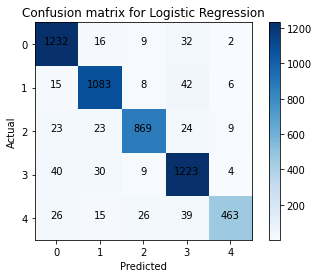

In [71]:
conf_matrix = confusion_matrix(y_test, y_test_pred)

plot_confusion_matrix(conf_matrix, 'Logistic Regression')#Plot the confusion matrix

### Decision Tree Classifier

In [72]:
# Write your code here to build any 3 models and evaluate them using the required metrics

dt = DecisionTreeClassifier(max_depth=10, random_state=100)#Initializing the model with random parameters.
dt.fit(X_train, y_train)

y_train_pred = dt.predict(X_train)# Predicted values of train dataset
y_test_pred = dt.predict(X_test)# Predicted values of test dataset

In [73]:
print(classification_report(y_test,y_test_pred))# Print the metrics Precision, Recall, F1-score and Accuracy

              precision    recall  f1-score   support

           0       0.75      0.82      0.78      1291
           1       0.80      0.80      0.80      1154
           2       0.88      0.70      0.78       948
           3       0.69      0.76      0.73      1306
           4       0.80      0.72      0.75       569

    accuracy                           0.77      5268
   macro avg       0.78      0.76      0.77      5268
weighted avg       0.77      0.77      0.77      5268



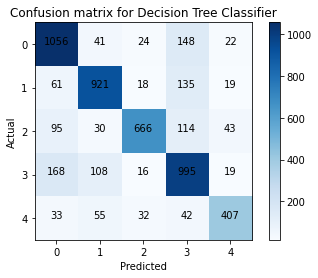

In [74]:
conf_matrix = confusion_matrix(y_test, y_test_pred)

plot_confusion_matrix(conf_matrix, 'Decision Tree Classifier')#Plot the confusion matrix

### Random Forest Classifier

In [75]:
rf = RandomForestClassifier(max_depth=20, random_state=100)#Initializing the model with random parameters.
rf.fit(X_train, y_train)

y_train_pred = rf.predict(X_train)# Predicted values of train dataset
y_test_pred = rf.predict(X_test)# Predicted values of test dataset

In [76]:
print(classification_report(y_test,y_test_pred))# Print the metrics Precision, Recall, F1-score and Accuracy

              precision    recall  f1-score   support

           0       0.77      0.89      0.82      1291
           1       0.74      0.82      0.78      1154
           2       0.86      0.82      0.84       948
           3       0.76      0.83      0.79      1306
           4       0.92      0.28      0.43       569

    accuracy                           0.78      5268
   macro avg       0.81      0.73      0.73      5268
weighted avg       0.79      0.78      0.77      5268



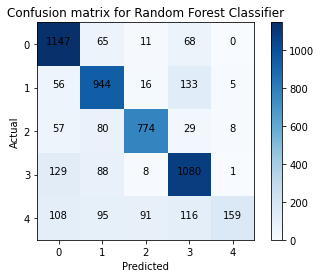

In [77]:
conf_matrix = confusion_matrix(y_test, y_test_pred)

plot_confusion_matrix(conf_matrix, 'Random Forest Classifier')#Plot the confusion matrix

### Naive Bayes Classifier

In [78]:
nb = MultinomialNB()#Initializing the model with random parameters.
nb.fit(X_train, y_train)

y_train_pred = nb.predict(X_train)# Predicted values of train dataset
y_test_pred = nb.predict(X_test)# Predicted values of test dataset

In [79]:
print(classification_report(y_test,y_test_pred))# Print the metrics Precision, Recall, F1-score and Accuracy

              precision    recall  f1-score   support

           0       0.70      0.89      0.79      1291
           1       0.78      0.66      0.72      1154
           2       0.88      0.74      0.80       948
           3       0.63      0.88      0.74      1306
           4       1.00      0.03      0.06       569

    accuracy                           0.72      5268
   macro avg       0.80      0.64      0.62      5268
weighted avg       0.77      0.72      0.68      5268



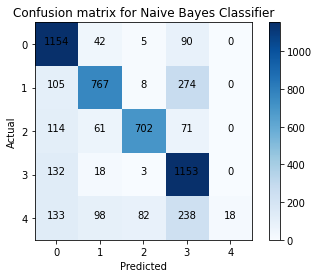

In [80]:
conf_matrix = confusion_matrix(y_test, y_test_pred)

plot_confusion_matrix(conf_matrix, 'Naive Bayes Classifier')#Plot the confusion matrix

**Below are the metrics obtained from various classification approaches.**

                Model	Precision	Recall	F1-Score Accuracy

        Logistic Regression	0.93	0.92	0.92	0.92

            Decision Tree	0.77	0.77	0.77	0.77

            Random Forest	0.79	0.78	0.77	0.78

                Naive Bayes	0.77	0.72	0.68	0.72


### Conclusion:

**Clearly, from the above metrics we can notice that, Precision/Recall/F1-score and Accuracy scores are highest for LOGISTIC REGRESSION.**

**Hence, we should go-ahead with Logistic Regression to perform the complaint classification.**

In [84]:
#Custom text to predict the Topic
custom_text1 = 'I opened an account with Citibank in XXXX. Then I moved to XXXX. I fully updated all my personal information and legal status throughout the process. Then, out of the blue, they decide to freeze my account! I did not receive any warning email. They did not send me any post to warn me of the freezing. I had money in the account and no cash in hand. And worst of all, they did this on a Friday, which means I had to wait until the following Tuesday until the customer service officer responsible for the freezing to come back to work. I had to spend 4 days without any cash in hand or withdrawal. I had to go to the currency exchange in order to buy my food! The employees at the XXXX branch in XXXX did their absolute best to help me out and resolve my case. I watched them call the customer service guys in front of me multiple times. No matter what they did or who they spoke to, the headquarters gave no satisfactory answer other than  Have him come back next Tuesday . When I came back on Tuesday, the only thing the bank could do for me to get my money back is to CLOSE THE ACCOUNT. Thats because the headquarters were unable to legally process my case. The bank employees advised me to take my money to another bank, because the headquarters were  too slow  in processing my case. I could have spent another 2 weeks with a frozen account while they took their sweet time. As of the time in which this problem occurred, I was ( and still am ) an XXXX from XXXX. That was my legal status in the USA. It was valid and supported by my lawyer. But the Citibank people had no experience dealing with my XXXX applicant status, and they did not communicate effectively why this problem happened. If they had told me about the problem EARLY ( at least through email! ), I would have talked to them and worked with them to fix it, not spending 4 days with no cash in hand.'
custom_text2 = 'We had a past experience with Wyndham Mortgage and would without question use again and again if needed!! Wyndham went beyond the extra mile to not only right a wrong encountered from the servicer we were dealing on our previous loan, but they pulled together and found a viable option for us that ultimately saved us money. We would highly recommend Brad Thomka and the Wyndham Capital Mortgage team for your mortgage needs. Sincerest thanks Wyndham!! Ed & Lind]'

In [85]:

def predict_topic(text):
    custom_txt = countVector.transform([text])

    custom_txt_tfidf = tfIdf_transform.transform(custom_txt)

    y_custom_text_topic_pred = lr.predict(custom_txt_tfidf)

    return y_custom_text_topic_pred


In [86]:
print(predict_topic(custom_text1))
print(predict_topic(custom_text2))

[0]
[2]


Clearly, the first random complaint is specific to Bank Account Services and the second complaint is specific to Mortgage related.

The model is able to rightly classify the complaint as 0 and 2 respectively.

'Bank Account services' : 0,
'Credit card or prepaid card' : 1 ,
'Mortgage/ Loan' : 2 ,
'Theft/Dispute Reporting' : 3 , 
'Others' : 4

### Summary:

1. Logistic Regression works well for our use case as compared to other classfication models. It predicts the right complaint category with an accuracy of 92%.
2. The model looks to work well with the custom random complaints as well.